# Defect Detection System

## Project Overview
This project implements a supervised deep learning system for **fabric defect detection**. The system classifies fabric images into defect categories such as **hole**, **vertical**, and **horizontal** defects using a **fine-tuned ResNet-18** model.

## Goal
The main goal is to build an efficient pipeline that can:

- Load and preprocess the fabric defect dataset
- Train a robust deep learning classifier
- Evaluate the model performance using metrics like accuracy, confusion matrix, and classification report
- Generate visual predictions to highlight detected defects


### 📌 1. Import Required Libraries & Configure Compute Device
This cell imports all essential Python packages used to build the supervised fabric defect classification pipeline.  
It includes:
- **PyTorch** for deep learning model training  
- **Torchvision** for dataset handling and pretrained models  
- **NumPy** and **Matplotlib** for visualization  
- **Scikit-learn** for evaluation metrics  

Finally, the code automatically selects **GPU (CUDA)** if available, otherwise falls back to **CPU**, ensuring compatibility across all machines.


In [10]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Using:", device)


Using: cpu


### 📌 2. Load Dataset & Prepare Train/Test Splits
This cell loads the Fabric Defect dataset using `ImageFolder`, which automatically assigns class labels based on folder names.  
Key steps include:

- Reading dataset directory  
- Extracting class names  
- Splitting data into **80% training** and **20% testing**  
- Applying appropriate **train** and **test transformations**  
- Creating PyTorch `DataLoader` objects for efficient batching  

This ensures a clean, scalable pipeline for model training and evaluation.


In [15]:
DATASET_DIR = r"C:\Users\PMYLS\Downloads\archive (7)\Data Set"


In [16]:
dataset = datasets.ImageFolder(DATASET_DIR, transform=train_tfms)

class_names = dataset.classes
print("Classes:", class_names)

# split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])

# apply test transforms to test set
test_ds.dataset.transform = test_tfms

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)


Classes: ['captured', 'hole', 'horizontal', 'verticle']


In [17]:
model = models.resnet18(weights="IMAGENET1K_V1")

# Change last layer → number of classes
model.fc = nn.Linear(model.fc.in_features, len(class_names))

model = model.to(device)


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/10 - Loss: 0.5679
Epoch 2/10 - Loss: 0.2387
Epoch 3/10 - Loss: 0.1585
Epoch 4/10 - Loss: 0.1060
Epoch 5/10 - Loss: 0.0946
Epoch 6/10 - Loss: 0.0617
Epoch 7/10 - Loss: 0.0452
Epoch 8/10 - Loss: 0.0663
Epoch 9/10 - Loss: 0.0321
Epoch 10/10 - Loss: 0.0167


In [19]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

    captured       1.00      1.00      1.00        55
        hole       1.00      0.92      0.96        38
  horizontal       0.93      1.00      0.96        27
    verticle       0.93      1.00      0.97        14

    accuracy                           0.98       134
   macro avg       0.97      0.98      0.97       134
weighted avg       0.98      0.98      0.98       134



### 📌 6. Utility Function for Predicting a Single Image
This function (`predict_image`) performs inference on an individual image.

Actions performed:
- Load and preprocess the input image  
- Run it through the trained model  
- Display the image with the predicted class label  
- Return the predicted class as a string  

This is useful for quick manual testing and validating results visually.


In [20]:
from PIL import Image

def predict_image(path):
    img = Image.open(path).convert("RGB")
    img_t = test_tfms(img).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        out = model(img_t)
        pred = torch.argmax(out).item()
    
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[pred]}")
    plt.axis("off")
    plt.show()
    
    return class_names[pred]


In [21]:
torch.save(model.state_dict(), "fabric_defect_resnet18.pth")


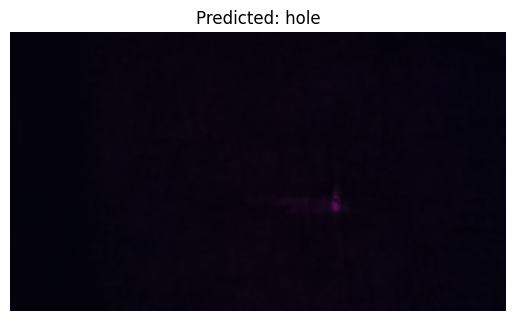

'hole'

In [23]:
predict_image(r"C:\Users\PMYLS\Downloads\archive (7)\Data Set\hole\2.jpg")


### 📌 7. Enhanced Prediction Function (with Confidence Score)
This function improves upon the basic prediction by:
- Computing class probabilities using **softmax**
- Displaying:
  - Predicted class  
  - Confidence percentage  
- Showing the input image for visual reference  

This makes the prediction more interpretable and suitable for reporting or deployment.


In [30]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

def show_prediction(path):
    model.eval()

    img = Image.open(path).convert("RGB")
    img_t = test_tfms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(img_t)
        probs = F.softmax(out, dim=1)[0]
        pred_idx = torch.argmax(out, dim=1).item()

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[pred_idx]}\nConfidence: {probs[pred_idx]*100:.2f}%")
    plt.axis("off")
    plt.show()


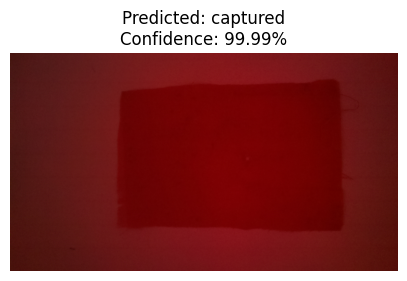

In [33]:
show_prediction(r"C:\Users\PMYLS\Downloads\archive (7)\Data Set\captured\Hole\hole_2018-10-11 13_39_55.527452.jpg")


### 📌 8. Visualize Model Predictions on Test Images
This visualization function (`visualize_test_predictions`) displays a grid of test images along with:

- Model predictions (P:…)
- True labels (T:…)

Each image is denormalized to its original appearance for proper viewing.

This provides a qualitative assessment of model performance and helps identify patterns in misclassification.


In [34]:
def visualize_test_predictions(model, test_loader, n=16):
    model.eval()
    images_shown = 0
    
    plt.figure(figsize=(12,12))

    for imgs, labels in test_loader:
        imgs = imgs.to(device)

        with torch.no_grad():
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

        for i in range(imgs.size(0)):
            if images_shown >= n:
                plt.tight_layout()
                plt.show()
                return

            plt.subplot(4, 4, images_shown + 1)
            img_np = imgs[i].cpu().permute(1,2,0).numpy()
            img_np = (img_np * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406])).clip(0,1)

            plt.imshow(img_np)
            title = f"P:{class_names[preds[i]]}\nT:{class_names[labels[i]]}"
            plt.title(title, fontsize=9)
            plt.axis("off")

            images_shown += 1


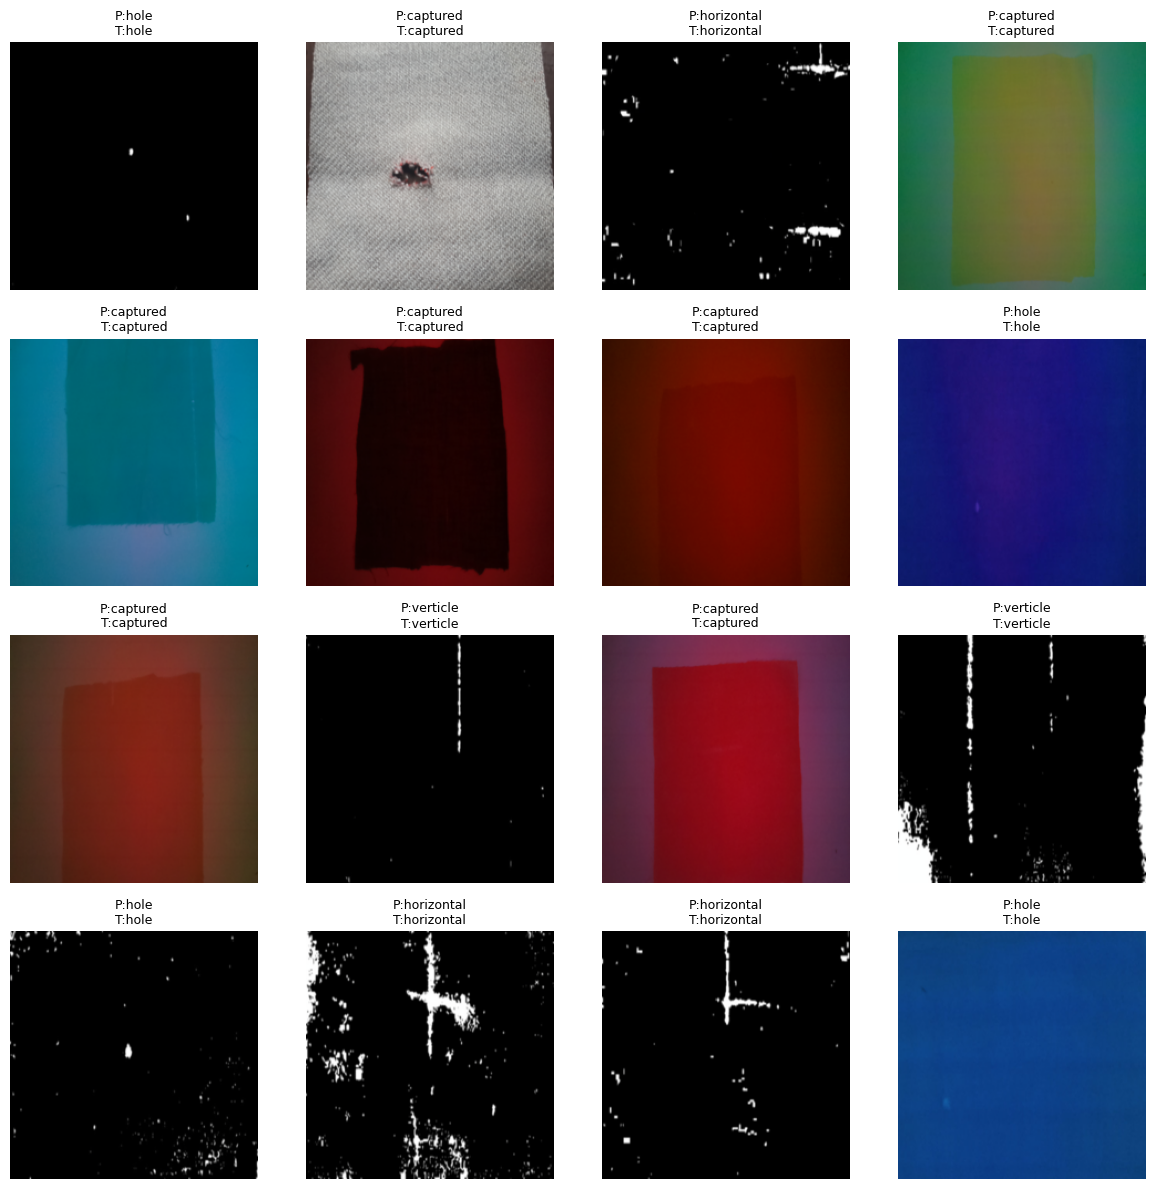

In [35]:
visualize_test_predictions(model, test_loader, n=16)


### 📌 9. Visualize Misclassified Samples
This cell identifies and displays misclassified test samples.

The function:
- Iterates through test images  
- Collects only those where **predicted ≠ true label**  
- Shows up to `n` misclassified examples in a grid  
- Displays predicted vs true labels  

This step is crucial for error analysis and helps understand model weaknesses or dataset inconsistencies.


In [40]:
def show_misclassified(model, test_loader, n=8):
    model.eval()
    mis_imgs = []
    mis_preds = []
    mis_true = []

    # collect misclassified samples
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        with torch.no_grad():
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

        for i in range(len(preds)):
            if preds[i].item() != labels[i].item():
                mis_imgs.append(imgs[i].cpu())
                mis_preds.append(preds[i].item())
                mis_true.append(labels[i].item())

                if len(mis_imgs) >= n:
                    break
        if len(mis_imgs) >= n:
            break

    # if no misclassified samples
    if len(mis_imgs) == 0:
        print("✔ No misclassified images — model is predicting everything correctly!")
        return

    # determine how many to show
    show_n = min(len(mis_imgs), n)

    # plot
    rows = (show_n + 3) // 4
    plt.figure(figsize=(12, 3*rows))

    for i in range(show_n):
        plt.subplot(rows, 4, i+1)
        img = mis_imgs[i].permute(1,2,0).numpy()
        img = (img * np.array([0.229,0.224,0.225]) +
               np.array([0.485,0.456,0.406])).clip(0,1)

        plt.imshow(img)
        plt.title(f"P:{class_names[mis_preds[i]]}\nT:{class_names[mis_true[i]]}", fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


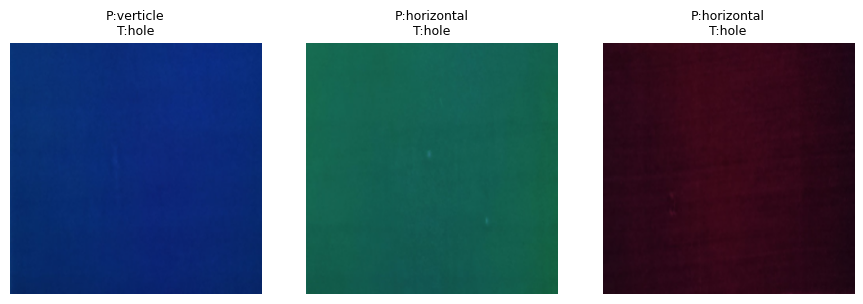

In [41]:
show_misclassified(model, test_loader, n=8)
